## **SPAM or HAM using Feature Based Transfer Learning with BERT**

Data downloaded from: https://www.kaggle.com/datasets/nitishabharathi/email-spam-dataset


In [28]:
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text
import pandas as pd
import numpy as np


In [29]:
df = pd.read_csv('enronSpamSubset.csv')

df.head()

,Unnamed: 0.1,Unnamed: 0,Body,Label
0,2469,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,5063,Subject: are you listed in major search engine...,1
2,12564,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,1468,"Subject: "" bidstogo "" is places to go , things...",1


Let's keep only the body and the label:

In [30]:
df_clean = df.iloc[:,2:]
df_clean.head()

,Body,Label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1


We can see that the dataset we chosen is already preprocessed to be balanced:

**1 means SPAM** and
**0 means HAM**

In [31]:
df_clean['Label'].value_counts()

1    5000
0    5000
Name: Label, dtype: int64

For computation reasons, we will keep only 500 spam and 500 ham emails, in order to show that BERT can work in small datasets.

In [49]:
df_spam = df_clean[df_clean['Label'] == 1]
df_spam_downsampled = df_spam.sample(500)
df_spam_downsampled.shape

(500, 2)

In [50]:
df_ham = df_clean[df_clean['Label'] == 0]
df_ham_downsampled = df_ham.sample(500)
df_ham_downsampled.shape

(500, 2)

In [51]:
df_balanced = pd.concat([df_ham_downsampled,df_spam_downsampled])

Let's now split the data to train and test:

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Body'], df_balanced['Label'], test_size=0.33, random_state=42)

X_train.shape

(670,)

We save the links we'll use to import BERT from tfhub. We we'll use **BERT Base**.

In [53]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

We save the model that preproccess our data, in order to have them in the form of [[CLS],Word1,Word2,....[SEP]] that is required from the encoder to be.

In [34]:
bert_preprocess_model = hub.KerasLayer(preprocess_url)
bert_encoder_model = hub.KerasLayer(encoder_url)

Create the model, that inputs text and outputs the binary prediction, spam or ham. **We give as input to the output neuron the "pooled output" of the text, which is actually the representation of the [CLS] token.**

In [54]:
#BERT Layers
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name='Input Layer')
preprocessed_text = bert_preprocess_model(text_input)
bert_outputs = bert_encoder_model(preprocessed_text)

#Neural Network Layers
x = tf.keras.layers.Dropout(0.1, name= 'dropout')(bert_outputs['pooled_output'])
x = tf.keras.layers.Dense(1,activation='sigmoid', name='Output')(x)

#Construct Final Model

model = tf.keras.models.Model(text_input,x)

In [55]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Layer (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['Input Layer[0][0]']            
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

Compile the model as we are using Recall as metric, to check how many spam does actually catches.

In [58]:
model.compile(
    optimizer='adam',
    loss= 'binary_crossentropy',
    metrics= tf.keras.metrics.Recall(name = 'recall')
)

In [60]:
r = model.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
21/21 [==============================] - 125s 6s/step - loss: 0.6916 - recall: 0.5433
Epoch 2/5
21/21 [==============================] - 127s 6s/step - loss: 0.6540 - recall: 0.6030
Epoch 3/5
21/21 [==============================] - 126s 6s/step - loss: 0.6207 - recall: 0.6657
Epoch 4/5
21/21 [==============================] - 128s 6s/step - loss: 0.6075 - recall: 0.6776
Epoch 5/5
21/21 [==============================] - 126s 6s/step - loss: 0.5970 - recall: 0.6507


In [61]:
r2 = model.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
21/21 [==============================] - 126s 6s/step - loss: 0.5755 - recall: 0.7075
Epoch 2/5
21/21 [==============================] - 128s 6s/step - loss: 0.5557 - recall: 0.7403
Epoch 3/5
21/21 [==============================] - 129s 6s/step - loss: 0.5489 - recall: 0.7284
Epoch 4/5
21/21 [==============================] - 128s 6s/step - loss: 0.5451 - recall: 0.7015
Epoch 5/5
21/21 [==============================] - 127s 6s/step - loss: 0.5277 - recall: 0.7821


In [62]:
r3 = model.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
21/21 [==============================] - 120s 6s/step - loss: 0.5101 - recall: 0.7791
Epoch 2/5
21/21 [==============================] - 117s 6s/step - loss: 0.5041 - recall: 0.8090
Epoch 3/5
21/21 [==============================] - 116s 6s/step - loss: 0.5002 - recall: 0.7970
Epoch 4/5
21/21 [==============================] - 129s 6s/step - loss: 0.4777 - recall: 0.8209
Epoch 5/5
21/21 [==============================] - 126s 6s/step - loss: 0.4788 - recall: 0.8239


In [63]:
r4 = model.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
21/21 [==============================] - 126s 6s/step - loss: 0.4644 - recall: 0.8000
Epoch 2/5
21/21 [==============================] - 117s 6s/step - loss: 0.4598 - recall: 0.8358
Epoch 3/5
21/21 [==============================] - 117s 6s/step - loss: 0.4605 - recall: 0.8209
Epoch 4/5
21/21 [==============================] - 118s 6s/step - loss: 0.4626 - recall: 0.8149
Epoch 5/5
21/21 [==============================] - 117s 6s/step - loss: 0.4530 - recall: 0.8328


In [64]:
r5 = model.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
21/21 [==============================] - 124s 6s/step - loss: 0.4448 - recall: 0.8209
Epoch 2/5
21/21 [==============================] - 125s 6s/step - loss: 0.4260 - recall: 0.8418
Epoch 3/5
21/21 [==============================] - 118s 6s/step - loss: 0.4315 - recall: 0.8090
Epoch 4/5
21/21 [==============================] - 123s 6s/step - loss: 0.4242 - recall: 0.8328
Epoch 5/5
21/21 [==============================] - 120s 6s/step - loss: 0.4233 - recall: 0.8358


In [65]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

11/11 [==============================] - 65s 6s/step


In [78]:
predictions = np.where(y_predicted>0.5,1,0)

predictions

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,

In [79]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,predictions)

Text(50.722222222222214, 0.5, 'True')

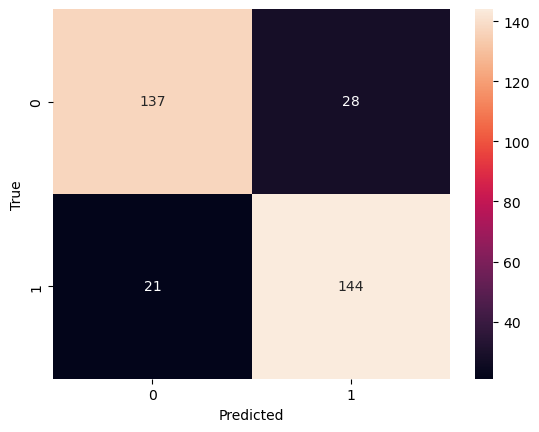

In [80]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
%plt.ylabel('True')

**We can clearly see that we can achieve easily 85% f1 score, with only using 670 training examples in order to train our logistic regression model. So BERT is a very powerfull encoder that can work even in small datasets without fine-tuning but by simply using it as a feature extractor and connecting it with 1 Dense Output Layer.**

In [81]:
from sklearn.metrics import f1_score

print(f1_score(y_test,predictions))

0.8545994065281899
